# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float64) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float64) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis=0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)

assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W0
Gradient check passed!
Checking gradient for B0
Gradient check passed!
Checking gradient for W1
Gradient check passed!
Checking gradient for B1
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
model_with_reg = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=3, reg=1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W0
Gradient check passed!
Checking gradient for B0
Gradient check passed!
Checking gradient for W1
Gradient check passed!
Checking gradient for B1
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [8]:
# Finally, implement predict function!

# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

In [9]:
# Set global seed to reproduce results
np.random.seed(0)

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [10]:
model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2)

# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 38.974832, Train accuracy: 0.321333, val accuracy: 0.331000
Loss: 46.589568, Train accuracy: 0.382333, val accuracy: 0.381000
Loss: 33.521919, Train accuracy: 0.525778, val accuracy: 0.530000
Loss: 37.915012, Train accuracy: 0.543333, val accuracy: 0.536000
Loss: 38.416140, Train accuracy: 0.567222, val accuracy: 0.537000
Loss: 44.036053, Train accuracy: 0.499667, val accuracy: 0.504000
Loss: 33.902768, Train accuracy: 0.581444, val accuracy: 0.586000
Loss: 40.537979, Train accuracy: 0.562111, val accuracy: 0.562000
Loss: 37.753202, Train accuracy: 0.583667, val accuracy: 0.591000
Loss: 27.370040, Train accuracy: 0.568556, val accuracy: 0.571000
Loss: 40.017292, Train accuracy: 0.561222, val accuracy: 0.572000
Loss: 35.779314, Train accuracy: 0.624222, val accuracy: 0.612000
Loss: 34.330192, Train accuracy: 0.593667, val accuracy: 0.577000
Loss: 27.500207, Train accuracy: 0.655556, val accuracy: 0.646000
Loss: 39.926743, Train accuracy: 0.565889, val accuracy: 0.524000
Loss: 31.8

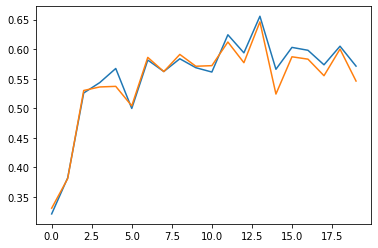

In [11]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [12]:
# Decay should happen once per epoch
model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 43.045442, Train accuracy: 0.310556, val accuracy: 0.310000
Loss: 28.234112, Train accuracy: 0.468667, val accuracy: 0.487000
Loss: 42.517803, Train accuracy: 0.494222, val accuracy: 0.495000
Loss: 38.303856, Train accuracy: 0.555222, val accuracy: 0.554000
Loss: 42.385502, Train accuracy: 0.539667, val accuracy: 0.528000
Loss: 24.623421, Train accuracy: 0.618111, val accuracy: 0.611000
Loss: 39.096049, Train accuracy: 0.554111, val accuracy: 0.534000
Loss: 30.866816, Train accuracy: 0.638000, val accuracy: 0.622000
Loss: 32.460275, Train accuracy: 0.583000, val accuracy: 0.583000
Loss: 36.399533, Train accuracy: 0.605778, val accuracy: 0.599000
Loss: 34.407670, Train accuracy: 0.603667, val accuracy: 0.596000
Loss: 31.882684, Train accuracy: 0.592111, val accuracy: 0.570000
Loss: 37.500617, Train accuracy: 0.600000, val accuracy: 0.601000
Loss: 30.521464, Train accuracy: 0.607333, val accuracy: 0.584000
Loss: 30.829812, Train accuracy: 0.628444, val accuracy: 0.617000
Loss: 34.4

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [13]:
model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 45.130735, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 47.817784, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 41.882024, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.421242, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 43.550153, Train accuracy: 0.203333, val accuracy: 0.212000
Loss: 40.558212, Train accuracy: 0.239778, val accuracy: 0.242000
Loss: 46.477837, Train accuracy: 0.260000, val accuracy: 0.256000
Loss: 37.244858, Train accuracy: 0.280333, val accuracy: 0.283000
Loss: 41.536190, Train accuracy: 0.351667, val accuracy: 0.357000
Loss: 40.337356, Train accuracy: 0.400333, val accuracy: 0.387000
Loss: 40.712674, Train accuracy: 0.437778, val accuracy: 0.425000
Loss: 40.498278, Train accuracy: 0.456222, val accuracy: 0.438000
Loss: 31.046233, Train accuracy: 0.475444, val accuracy: 0.471000
Loss: 29.164389, Train accuracy: 0.517000, val accuracy: 0.518000
Loss: 34.598313, Train accuracy: 0.555333, val accuracy: 0.542000
Loss: 29.4

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [14]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 11.543333, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.515804, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.416036, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.512466, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.518150, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.507092, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 11.428596, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 11.457868, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.350407, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.052376, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.414579, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.394177, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.091690, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.940510, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 11.265364, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 10.8

Loss: 2.544668, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 2.024289, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 2.214200, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 2.203441, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.762515, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.737859, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.083798, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.767356, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.924184, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.968692, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.801435, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.630370, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.047542, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.559490, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.400013, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.461449, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [15]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-3)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 11.567885, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.507250, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.380340, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.089365, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 10.861243, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.822692, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: 11.080648, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 11.485191, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 8.375465, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 8.039102, Train accuracy: 0.400000, val accuracy: 0.133333
Loss: 9.587526, Train accuracy: 0.533333, val accuracy: 0.066667
Loss: 6.027564, Train accuracy: 0.600000, val accuracy: 0.066667
Loss: 5.891355, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 2.692595, Train accuracy: 0.666667, val accuracy: 0.066667
Loss: 3.780427, Train accuracy: 0.666667, val accuracy: 0.066667
Loss: 4.512810, T

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [16]:
# Let's train the best one-hidden-layer network we can

learning_rates = [1e-4]
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = 0

loss_history = []
train_history = []
val_history = []

# find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
dataset = Dataset(train_X, train_y, val_X, val_y)
for lr in learning_rates:
    model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=hidden_layer_size, reg=reg_strength)
    trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=lr, num_epochs=num_epochs, batch_size=batch_size, learning_rate_decay=learning_rate_decay)
    loss, train_acc, val_acc = trainer.fit()
    
    accuracy = multiclass_accuracy(model.predict(val_X), val_y)
    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_classifier = model
        loss_history = loss
        train_history = train_acc
        val_history = val_acc

print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 89.122774, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 87.322544, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 87.159499, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 83.367419, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 84.431398, Train accuracy: 0.216778, val accuracy: 0.225000
Loss: 92.169960, Train accuracy: 0.261444, val accuracy: 0.254000
Loss: 81.902267, Train accuracy: 0.288111, val accuracy: 0.294000
Loss: 71.420590, Train accuracy: 0.373000, val accuracy: 0.371000
Loss: 86.561965, Train accuracy: 0.431333, val accuracy: 0.421000
Loss: 64.619691, Train accuracy: 0.467444, val accuracy: 0.452000
Loss: 54.182753, Train accuracy: 0.503778, val accuracy: 0.505000
Loss: 52.888214, Train accuracy: 0.553556, val accuracy: 0.550000
Loss: 57.543887, Train accuracy: 0.584889, val accuracy: 0.572000
Loss: 40.727394, Train accuracy: 0.600111, val accuracy: 0.587000
Loss: 36.457883, Train accuracy: 0.640778, val accuracy: 0.611000
Loss: 45.6

Loss: 2.423644, Train accuracy: 0.975778, val accuracy: 0.761000
Loss: 4.129473, Train accuracy: 0.984000, val accuracy: 0.762000
Loss: 7.630939, Train accuracy: 0.982667, val accuracy: 0.763000
Loss: 8.839604, Train accuracy: 0.976444, val accuracy: 0.757000
Loss: 6.224874, Train accuracy: 0.982778, val accuracy: 0.767000
Loss: 5.954625, Train accuracy: 0.985444, val accuracy: 0.763000
Loss: 4.538530, Train accuracy: 0.984444, val accuracy: 0.772000
Loss: 6.197976, Train accuracy: 0.987000, val accuracy: 0.768000
Loss: 3.676839, Train accuracy: 0.985222, val accuracy: 0.763000
Loss: 6.309856, Train accuracy: 0.986556, val accuracy: 0.763000
Loss: 3.883364, Train accuracy: 0.985111, val accuracy: 0.764000
Loss: 5.813243, Train accuracy: 0.985889, val accuracy: 0.760000
Loss: 8.737198, Train accuracy: 0.981222, val accuracy: 0.762000
Loss: 5.203320, Train accuracy: 0.986556, val accuracy: 0.766000
Loss: 5.772041, Train accuracy: 0.979667, val accuracy: 0.762000
Loss: 4.250547, Train acc

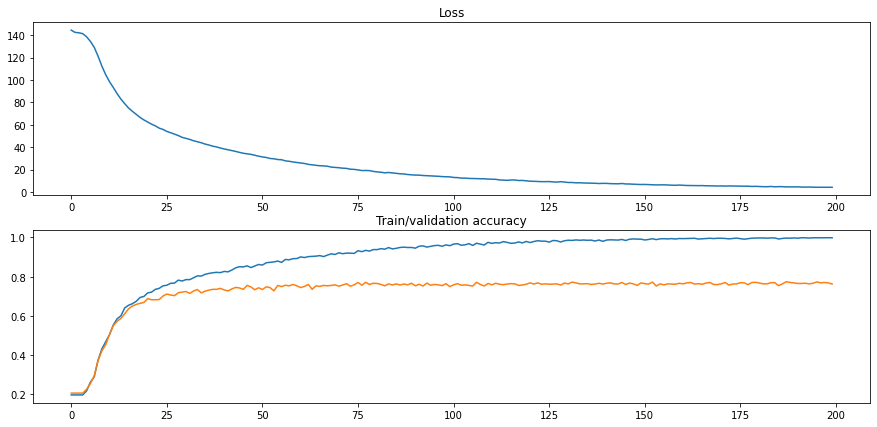

In [17]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [18]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.753000
